In [48]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.metrics import roc_curve, confusion_matrix, classification_report, precision_recall_curve, roc_auc_score

In [49]:
marketing_raw = pd.read_csv('data/marketing_data.csv')
marketing_raw.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Response,Complain,Country
0,1826,1970,Graduation,Divorced,"$84,835.00",0,0,6/16/14,0,189,...,6,1,0,0,0,0,0,1,0,SP
1,1,1961,Graduation,Single,"$57,091.00",0,0,6/15/14,0,464,...,7,5,0,0,0,0,1,1,0,CA
2,10476,1958,Graduation,Married,"$67,267.00",0,1,5/13/14,0,134,...,5,2,0,0,0,0,0,0,0,US
3,1386,1967,Graduation,Together,"$32,474.00",1,1,05-11-2014,0,10,...,2,7,0,0,0,0,0,0,0,AUS
4,5371,1989,Graduation,Single,"$21,474.00",1,0,04-08-2014,0,6,...,2,7,1,0,0,0,0,1,0,SP


In [50]:
marketing_raw['Income'] = pd.to_numeric(marketing_raw['Income'].str.replace('\$|,' , '' , regex=True))
marketing_raw['Income'].fillna(marketing_raw['Income'].mean(), inplace=True)
marketing_raw['Age'] = 2014 - marketing_raw['Year_Birth']
marketing_raw['Dt_Customer'] = pd.to_datetime(marketing_raw['Dt_Customer'])
marketing_raw['days_since_joining'] = (datetime(2014, 6, 30) - marketing_raw['Dt_Customer']).dt.days
marketing_raw.dtypes

ID                              int64
Year_Birth                      int64
Education                      object
Marital_Status                 object
Income                        float64
Kidhome                         int64
Teenhome                        int64
Dt_Customer            datetime64[ns]
Recency                         int64
MntWines                        int64
MntFruits                       int64
MntMeatProducts                 int64
MntFishProducts                 int64
MntSweetProducts                int64
MntGoldProds                    int64
NumDealsPurchases               int64
NumWebPurchases                 int64
NumCatalogPurchases             int64
NumStorePurchases               int64
NumWebVisitsMonth               int64
AcceptedCmp3                    int64
AcceptedCmp4                    int64
AcceptedCmp5                    int64
AcceptedCmp1                    int64
AcceptedCmp2                    int64
Response                        int64
Complain    

In [51]:
## Some more features
marketing_raw['Age_bin'] = 'Unknown'
marketing_raw.loc[marketing_raw['Age'].between(0, 34, inclusive=True), 'Age_bin'] = 'Age_under35'
marketing_raw.loc[marketing_raw['Age'].between(35, 44, inclusive=True), 'Age_bin'] = 'Age_35_44'
marketing_raw.loc[marketing_raw['Age'].between(45, 59, inclusive=True), 'Age_bin'] = 'Age_45_59'
marketing_raw.loc[marketing_raw['Age'].between(60, 150, inclusive=True), 'Age_bin'] = 'Age_above59'
marketing_raw.head(10)

marketing_raw['Income_bin'] = 'Unknown'
marketing_raw.loc[marketing_raw['Income'].between(0, 34999, inclusive=True), 'Income_bin'] = 'Income_under35k'
marketing_raw.loc[marketing_raw['Income'].between(35000, 64999, inclusive=True), 'Income_bin'] = 'Income_35k_65k'
marketing_raw.loc[marketing_raw['Income'].between(65000, 999999, inclusive=True), 'Income_bin'] = 'Income_above65k'

marketing_raw['People_at_home'] = np.nan
marketing_raw.loc[marketing_raw['Marital_Status'].isin(['Married','Together']), 'People_at_home'] = marketing_raw['Kidhome'] + marketing_raw['Teenhome'] + 2 
marketing_raw.loc[~marketing_raw['Marital_Status'].isin(['Married','Together']), 'People_at_home'] = marketing_raw['Kidhome'] + marketing_raw['Teenhome'] + 1 

marketing_raw['Income_per_person'] = marketing_raw['Income']/marketing_raw['People_at_home']

marketing_raw['Response1'] = marketing_raw['Response'] + marketing_raw['AcceptedCmp1'] + marketing_raw['AcceptedCmp2'] +\
marketing_raw['AcceptedCmp3'] + marketing_raw['AcceptedCmp4'] + marketing_raw['AcceptedCmp5']
marketing_raw['Response'] = [1 if x>0 else 0 for x in marketing_raw['Response1']]
# Response is 1 if any of the accepted campaigns is 1

marketing_raw.describe()

,ID,Year_Birth,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,...,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Response,Complain,Age,days_since_joining,People_at_home,Income_per_person,Response1
count,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,...,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000
mean,5592.159821,1968.805804,52247.251354,0.444196,0.506250,49.109375,303.935714,26.302232,166.950000,37.525446,...,0.072768,0.064286,0.013393,0.271875,0.009375,45.194196,354.582143,2.595089,24957.405670,0.446875
std,3246.662198,11.984069,25037.797168,0.538398,0.544538,28.962453,336.597393,39.773434,225.715373,54.628979,...,0.259813,0.245316,0.114976,0.445025,0.096391,11.984069,202.122512,0.906959,19863.973231,0.890543
min,0.000000,1893.000000,1730.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,18.000000,1.000000,1.000000,815.666667,0.000000
25%,2828.250000,1959.000000,35538.750000,0.000000,0.000000,24.000000,23.750000,1.000000,16.000000,3.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,37.000000,181.750000,2.000000,12181.187500,0.000000
50%,5458.500000,1970.000000,51741.500000,0.000000,0.000000,49.000000,173.500000,8.000000,67.000000,12.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,44.000000,356.500000,3.000000,18607.166667,0.000000
75%,8427.750000,1977.000000,68289.750000,1.000000,1.000000,74.000000,504.250000,33.000000,232.000000,50.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,55.000000,530.000000,3.000000,31920.500000,1.000000
max,11191.000000,1996.000000,666666.000000,2.000000,2.000000,99.000000,1493.000000,199.000000,1725.000000,259.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,121.000000,700.000000,5.000000,222222.000000,5.000000


In [52]:
## Creating one hot variables
edu_dummies = pd.get_dummies(marketing_raw['Education'])
marital_dummies = pd.get_dummies(marketing_raw['Marital_Status'])
country_dummies = pd.get_dummies(marketing_raw['Country'])
age_dummies = pd.get_dummies(marketing_raw['Age_bin'])
income_dummies = pd.get_dummies(marketing_raw['Income_bin'])
marketing = pd.concat([marketing_raw, edu_dummies, marital_dummies, country_dummies,age_dummies, income_dummies], axis=1)
marketing.head()
marketing.to_csv('data/marketing_features.csv', index=False)

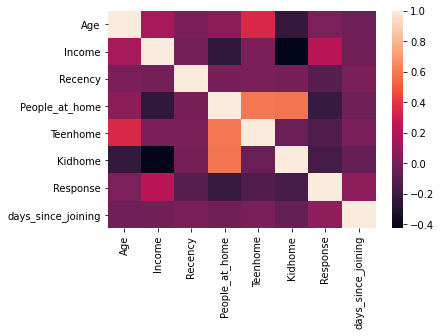

In [53]:
corrMatrix = marketing_raw[['Age','Income','Recency','People_at_home','Teenhome','Kidhome','Response','days_since_joining']].corr()
sns.heatmap(corrMatrix)
plt.show()

## Logistic Model

In [54]:
X_int = marketing_raw[['Income','Teenhome','Recency','NumWebVisitsMonth']] 
X_int1 = pd.concat([X_int, edu_dummies, marital_dummies], axis=1)
X = X_int1.drop(['Basic','2n Cycle','Graduation','Master','Alone','Absurd','YOLO','Widow','Single','Divorced'], axis=1)
# Dropping one big bucket from each category to avoid perfect collinearity and very small buckets because they will not contribute much
# Dropping age, countries and other insignificant categories
y = marketing_raw['Response']

In [55]:
## Train Val Test Split (80-10-10)
X_train_int, X_test, y_train_int, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_int, y_train_int, test_size=0.1111, random_state=42)

In [56]:
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

(1792, 7) (1792,)
(224, 7) (224,)
(224, 7) (224,)


In [57]:
X_train_const = sm.add_constant(X_train)
X_val_const = sm.add_constant(X_val)
base_log = sm.Logit(y_train, X_train_const).fit()
base_log.summary()

Optimization terminated successfully.
         Current function value: 0.513189
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               Response   No. Observations:                 1792
Model:                          Logit   Df Residuals:                     1784
Method:                           MLE   Df Model:                            7
Date:                Wed, 02 Jun 2021   Pseudo R-squ.:                  0.1268
Time:                        17:49:28   Log-Likelihood:                -919.64
converged:                       True   LL-Null:                       -1053.2
Covariance Type:            nonrobust   LLR p-value:                 6.094e-54
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -4.3688      0.383    -11.407      0.000      -5.119      -3.618
Income             5.332e-05   4.17e-06     12.797      0.000    4.52e-05    6.15e-05
Teenhome             -0.7930      0.115     -6.903      0.000      -1.018      -0.568
Recency              -0.0089      0.002     -4.434      0.000      -0.013      -0.005
NumWebVisitsMonth     0.2722      0.033      8.281      0.000       0.208       0.337
PhD                   0.2848      0.134      2.124      0.034       0.022       0.548
Married              -0.3504      0.133     -2.643      0.008      -0.610      -0.091
Together             -0.3074      0.147     -2.087      0.037      -0.596      -0.019
=====================================================================================
"""

In [58]:
y_val_prob = base_log.predict(X_val_const) 
y_val_pred = [1 if x>0.34 else 0 for x in y_val_prob]

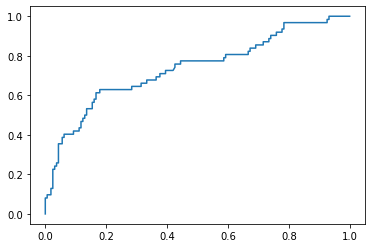

In [59]:
fpr, tpr, thres = roc_curve(y_val, y_val_prob)
plt.plot(fpr, tpr)

In [60]:
precision, recall, thres = precision_recall_curve(y_val, y_val_prob)
d = {'precision':precision[:-1],'recall':recall[:-1], 'thres':thres}
metrics = pd.DataFrame(d)
metrics['f1'] = 2*metrics['precision']*metrics['recall']/(metrics['precision']+metrics['recall'])
metrics[100:160]
# plt.plot(recall, precision)

,precision,recall,thres,f1
100,0.405405,0.725806,0.219633,0.520231
101,0.409091,0.725806,0.220928,0.523256
102,0.412844,0.725806,0.222677,0.526316
103,0.407407,0.709677,0.226092,0.517647
104,0.411215,0.709677,0.226480,0.520710
105,0.415094,0.709677,0.229454,0.523810
106,0.419048,0.709677,0.229801,0.526946
107,0.413462,0.693548,0.230497,0.518072
108,0.417476,0.693548,0.240061,0.521212
109,0.421569,0.693548,0.244241,0.524390


In [61]:
print('Confusion Matrix:')
print(confusion_matrix(y_val, y_val_pred))
print('Classification Report:')
print(classification_report(y_val, y_val_pred))
print('AUC ROC:')
print(roc_auc_score(y_val,y_val_pred))

Confusion Matrix:
[[131  31]
 [ 23  39]]
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.81      0.83       162
           1       0.56      0.63      0.59        62

    accuracy                           0.76       224
   macro avg       0.70      0.72      0.71       224
weighted avg       0.77      0.76      0.76       224

AUC ROC:
0.7188371166865791


## Test Performance

In [62]:
X_test_const = sm.add_constant(X_test)
y_test_prob = base_log.predict(X_test_const) 
y_test_pred = [1 if x>0.34 else 0 for x in y_test_prob]

In [63]:
print('Confusion Matrix:')
print(confusion_matrix(y_test, y_test_pred))
print('Classification Report:')
print(classification_report(y_test, y_test_pred))
print('AUC ROC:')
print(roc_auc_score(y_test,y_test_pred))

Confusion Matrix:
[[128  41]
 [ 20  35]]
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.76      0.81       169
           1       0.46      0.64      0.53        55

    accuracy                           0.73       224
   macro avg       0.66      0.70      0.67       224
weighted avg       0.77      0.73      0.74       224

AUC ROC:
0.6968800430338892


## Final Remarks -

1) Logistic Regression has given better results because it gives fewer false negatives
2) I seem to have overfit in logistic regression by tuning threshold excessively
3) Further error analysis can be done to get further insights

In [72]:
corrects = y_val==y_val_pred
X_val['corrects'] = corrects
X_val['actual'] = y_val
X_val['predicted'] = y_val_pred
X_val['prob'] = y_val_prob
X_val['error'] = X_val['actual'] - X_val['prob']
X_val['coeff'] = -4.3688
X_val['Income_cont'] = 5.332e-05 * X_val['Income']
X_val['Teen_cont'] = -0.7930 * X_val['Teenhome']
X_val['Recency_cont'] = -0.0089 * X_val['Recency']
X_val['Visits_cont'] = 0.2722 * X_val['NumWebVisitsMonth']
X_val['PhD_cont'] = 0.2848 * X_val['PhD']
X_val['Married_cont'] = -0.3504 * X_val['Married']
X_val['Together_cont'] = -0.3074 * X_val['Together']
X_val['wTx'] = X_val['coeff'] + X_val['Income_cont'] + X_val['Teen_cont'] + X_val['Recency_cont'] + X_val['Visits_cont'] + \
X_val['PhD_cont'] + X_val['Married_cont'] + X_val['Together_cont']
X_val['score'] = 1/(1+np.exp(-1*X_val['wTx']))

/home/kevin/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/kevin/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/kevin/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFr

In [74]:
pd.set_option('display.max_columns', 50)
X_val[X_val['corrects']==False]

,Income,Teenhome,Recency,NumWebVisitsMonth,PhD,Married,Together,corrects,actual,predicted,prob,error,coeff,Income_cont,Teen_cont,Recency_cont,Visits_cont,PhD_cont,Married_cont,Together_cont,wTx,score
27,54450.0,1,0,8,0,0,1,False,0,1,0.404047,-0.404047,-4.3688,2.903274,-0.793,-0.0000,2.1776,0.0000,-0.0000,-0.3074,-0.388326,0.404120
1571,61180.0,1,70,3,0,1,0,False,1,0,0.113069,0.886931,-4.3688,3.262118,-0.793,-0.6230,0.8166,0.0000,-0.3504,-0.0000,-2.056482,0.113399
735,37717.0,0,31,9,1,1,0,False,0,1,0.437540,-0.437540,-4.3688,2.011070,-0.000,-0.2759,2.4498,0.2848,-0.3504,-0.0000,-0.249430,0.437964
263,55521.0,2,11,7,1,0,0,False,1,0,0.288463,0.711537,-4.3688,2.960380,-1.586,-0.0979,1.9054,0.2848,-0.0000,-0.0000,-0.902120,0.288615
1393,87000.0,0,61,2,0,1,0,False,0,1,0.479580,-0.479580,-4.3688,4.638840,-0.000,-0.5429,0.5444,0.0000,-0.3504,-0.0000,-0.078860,0.480295
1585,38097.0,1,70,7,1,1,0,False,1,0,0.128190,0.871810,-4.3688,2.031332,-0.793,-0.6230,1.9054,0.2848,-0.3504,-0.0000,-1.913668,0.128569
2033,37244.0,1,90,7,0,0,0,False,1,0,0.111466,0.888534,-4.3688,1.985850,-0.793,-0.8010,1.9054,0.0000,-0.0000,-0.0000,-2.071550,0.111893
1156,67433.0,2,51,4,0,1,0,False,1,0,0.111330,0.888670,-4.3688,3.595528,-1.586,-0.4539,1.0888,0.0000,-0.3504,-0.0000,-2.074772,0.111573
1986,50127.0,1,88,6,0,0,1,False,1,0,0.124487,0.875513,-4.3688,2.672772,-0.793,-0.7832,1.6332,0.0000,-0.0000,-0.3074,-1.946428,0.124943
269,46049.0,1,11,7,0,1,0,False,1,0,0.222677,0.777323,-4.3688,2.455333,-0.793,-0.0979,1.9054,0.0000,-0.3504,-0.0000,-1.249367,0.222810
